In [1]:
#Dependencies
!pip install -U pip
!pip install accelerate==0.18.0
!pip install appdirs==1.4.4
!pip install bitsandbytes==0.37.2
!pip install datasets==2.10.1
!pip install fire==0.5.0
!pip install git+https://github.com/huggingface/peft.git
!pip install git+https://github.com/huggingface/transformers.git
!pip install torch==2.0.0
!pip install sentencepiece==0.1.97
!pip install tensorboardX==2.6
!pip install gradio==3.23.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.9 MB/s eta 0:00:00
  Obtaining dependency information for xxhash from https://files.pythonhosted.org/packages/13/c3/e942893f4864a424514c81640f114980cfd5aff7e7414d1e0255f4571111/xxhash-3.3.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for multiprocess from https://files.pythonhosted.org/packages/35/a8/36d8d7b3e46b377800d8dec47891cdf05842d1a2366909ae4a0c89fbc5e6/multiprocess-0.70.15-py310-none-any.whl.metadata
  O

In [25]:
!pip install accelerate
!pip install bitsandbytes

In [2]:
#Packages
import transformers
import textwrap
from transformers import LlamaTokenizer, LlamaForCausalLM
import os
import sys
from typing import List

from peft import (
    LoraConfig,
    get_peft_model,
    get_peft_model_state_dict,
    prepare_model_for_int8_training,
)

import fire
import torch
from datasets import load_dataset
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pylab import rcParams


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA SETUP: Required library version not found: libsbitsandbytes_cpu.so. Maybe you need to compile it from source?
CUDA SETUP: Defaulting to libbitsandbytes_cpu.so...


/usr/local/lib/python3.10/dist-packages/bitsandbytes/cextension.py:31: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


In [3]:
#Matplotlib Plotting Settings
%matplotlib inline
sns.set(rc={'figure.figsize':(10, 7)})
sns.set(rc={'figure.dpi':100})
sns.set(style='white', palette='muted', font_scale=1.2)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

In [4]:
#Download data from Kaggle
!gdown 1xQ89cpZCnafsW5T3G3ZQWvR7q682t2BN


Downloading...
From: https://drive.google.com/uc?id=1xQ89cpZCnafsW5T3G3ZQWvR7q682t2BN
To: /content/bitcoin-sentiment-tweets.csv
100% 242k/242k [00:00<00:00, 84.7MB/s]


In [5]:
df = pd.read_csv("bitcoin-sentiment-tweets.csv")
df.head()

,date,tweet,sentiment
0,Fri Mar 23 00:40:40 +0000 2018,@p0nd3ea Bitcoin wasn't built to live on excha...,1.0
1,Fri Mar 23 00:40:40 +0000 2018,@historyinflicks Buddy if I had whatever serie...,1.0
2,Fri Mar 23 00:40:42 +0000 2018,@eatBCH @Bitcoin @signalapp @myWickr @Samsung ...,0.0
3,Fri Mar 23 00:41:04 +0000 2018,@aantonop Even if Bitcoin crash tomorrow morni...,0.0
4,Fri Mar 23 00:41:07 +0000 2018,I am experimenting whether I can live only wit...,1.0


<Axes: >

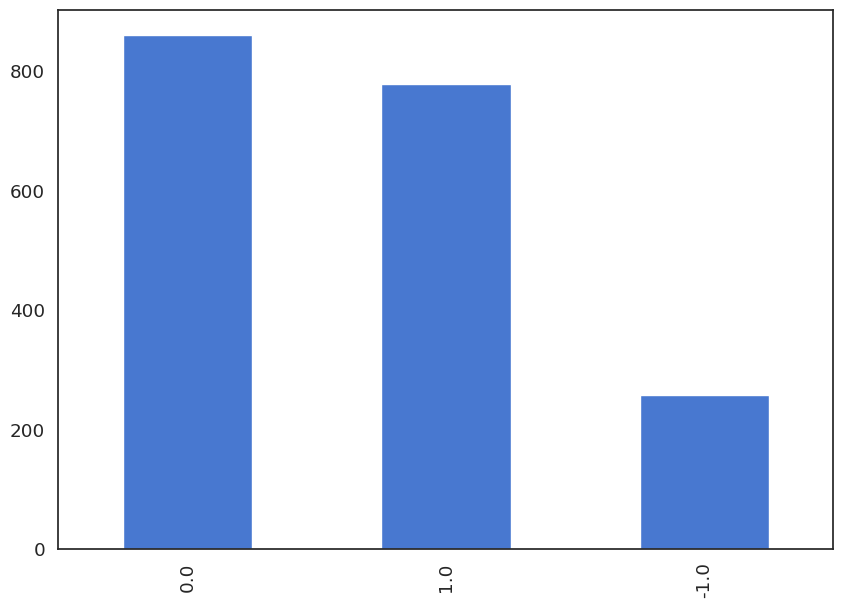

In [6]:
df['sentiment'].value_counts().plot(kind="bar")

## The basic data format that the Alpaca repository accepts are JSON files with objects "instruction", "input", "output"

So best to adapt this dataset to a JSON format so it's accepted by the model

In [12]:
def sentiment_score_to_name(score: float):
  print(score)
  if score > 0:
    return "Positive"
  elif score < 0:
    return "Negative"
  return "Neutral"

dataset_data = [
     {
        "instruction": "Detect the sentiment of the tweet.",
        "input": row_dict["tweet"],
        "output": sentiment_score_to_name(row_dict["sentiment"])
    }
    for row_dict in df.to_dict(orient="records")
]

dataset_data[0]

1.0
1.0
0.0
0.0
1.0
0.0
0.0
-1.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
0.0
-1.0
-1.0
1.0
0.0
0.0
1.0
0.0
1.0
1.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
-1.0
0.0
1.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
-1.0
0.0
0.0
1.0
-1.0
1.0
1.0
0.0
0.0
-1.0
0.0
1.0
0.0
1.0
1.0
0.0
0.0
-1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
-1.0
0.0
0.0
0.0
-1.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
1.0
1.0
-1.0
0.0
1.0
0.0
1.0
-1.0
1.0
1.0
1.0
0.0
-1.0
-1.0
1.0
-1.0
0.0
1.0
0.0
1.0
0.0
1.0
-1.0
0.0
1.0
1.0
-1.0
1.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
-1.0
-1.0
1.0
1.0
1.0
-1.0
0.0
0.0
0.0
0.0
0.0
-1.0
1.0
1.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
-1.0
1.0
1.0
1.0
1.0
-1.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
-1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
1.0
0.0
-1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
-1.0
1.0
1.0
-1.0
0.0
1.0
0.0
1.0
1.0
1.0
0.0

{'instruction': 'Detect the sentiment of the tweet.',
 'input': "@p0nd3ea Bitcoin wasn't built to live on exchanges.",
 'output': 'Positive'}

In [20]:
dataset_data[0]

{'instruction': 'Detect the sentiment of the tweet.',
 'input': "@p0nd3ea Bitcoin wasn't built to live on exchanges.",
 'output': 'Positive'}

In [21]:
#Save json file

import json
with open("alpaca-btc-sentiment.json", "w") as f:
  json.dump(dataset_data, f)

## Set model weights using the leaked 'decapoda-research' weights

In [27]:
!pip install -i https://test.pypi.org/simple/ bitsandbytes

Looking in indexes: https://test.pypi.org/simple/


In [32]:
BASE_MODEL = "decapoda-research/llama-7b-hf"

model = LlamaForCausalLM.from_pretrained(
    BASE_MODEL,
    # load_in_8bit = True, # Improve inference speed and reduce memory usage
    torch_dtype = torch.float16,
    device_map = "auto",
    offload_folder = "offload"
)

tokenizer = LlamaTokenizer.from_pretrained(BASE_MODEL) #pretrained weights

tokenizer.pad_token_id = (0)
tokenizer.padding_side = "left" #Pad sequences on left side

Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LLaMATokenizer'. 
The class this function is called from is 'LlamaTokenizer'.
Loading the tokenizer from the `special_tokens_map.json` and the `added_tokens.json` will be removed in `transformers 5`,  it is kept for forward compatibility, but it is recommended to update your `tokenizer_config.json` by uploading it again. You will see the new `added_tokens_decoder` attribute that will store the relevant information.
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what

## Load in the dataset

In [33]:
data = load_dataset("json", data_files = "alpaca-btc-sentiment.json")
data['train']

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-7b38ba9c11b7368f/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 1897
})

### Create prompts and tokenize them

In [38]:
CUTOFF_LEN = 2048 #Default max for the Llama models

def generate_prompt(data_point):
  #this is the prompt that the LLM would see. We keep it consistent
  return f"""
  Below is an instruction that describes a task paired witha n input that provides further context. Write a response that appropriately completes the request. # noqa:E501
  ### Instruction:
  {data_point["instruction"]}
  ### Input:
  {data_point["input"]}
  ### Response:
  {data_point["output"]}
  """

def tokenize(prompt, add_eos_token=True):
  result = tokenizer( #Uses tokenizer defined earlier, that tokenizes strings into values the LLM can understand
      prompt,
      truncation = True,
      max_length = CUTOFF_LEN,
      padding = False, #Why would we want padding?
      return_tensors = None)

  if (result["input_ids"][-1] != tokenizer.eos_token_id and len(result["input_ids"]) < CUTOFF_LEN and add_eos_token):
    result["input_ids"].append(tokenizer.eos_token_id)
    result["attention_mask"].append(1)
      #What do these two steps really do

  result["labels"] = result["input_ids"].copy()

  return result

def generate_and_tokenize_prompt(data_point):
  full_prompt = generate_prompt(data_point)
  tokenized_full_prompt = tokenize(full_prompt)
  return tokenized_full_prompt

In [39]:
train_val = data["train"].train_test_split(
    test_size = 200, shuffle = True, seed = 42
)

train_data = (
    train_val["train"].map(generate_and_tokenize_prompt)
)

val_data = (
    train_val["test"].map(generate_and_tokenize_prompt)
)

Map:   0%|          | 0/1697 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

## Training

In [40]:
#Finetuning parameters
LORA_R = 8
LORA_ALPHA = 16
LORA_DROPOUT = 0.05
LORA_TARGET_MODULES = [
    "q_proj",
    "v_proj"
]

BATCH_SIZE = 128
MICRO_BATCH_SIZE = 4
GRADIENT_ACCUMULATION_SETPS = BATCH_SIZE // MICRO_BATCH_SIZE
  #Update steps for gradients before a backward pass
LEARNING_RATE = 3e-4
TRAIN_STEPS = 300
OUTPUT_DIR = "experiments"

In [2]:
model = prepare_model_for_kbit_training(model)
config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    target_modules=LORA_TARGET_MODULES,
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, config)
model.print_trainable_parameters()

NameError: ignored

In [ ]:
#HuggingFace transformer library
training_arguments = transformers.TrainingArguments(
    per_device_train_batch_size=MICRO_BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    warmup_steps=100,
    max_steps=TRAIN_STEPS,
    learning_rate=LEARNING_RATE,
    fp16=True,
    logging_steps=10,
    optim="adamw_torch",
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=50,
    save_steps=50,
    output_dir=OUTPUT_DIR,
    save_total_limit=3,
    load_best_model_at_end=True,
    report_to="tensorboard"
)

In [ ]:
data_collator = transformers.DataCollatorForSeq2Seq(
    tokenizer, pad_to_multiple_of=8, return_tensors="pt", padding=True
)
  #maximum sequence length is amultiple of 8
  # Add padding to reach the required length (equal length outputs for the model)


#HF Transformers class that creates batches for seq2seq models

In [ ]:
trainer = transformers.Trainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=val_data,
    args=training_arguments,
    data_collator=data_collator
)
model.config.use_cache = False
old_state_dict = model.state_dict
model.state_dict = (
    lambda self, *_, **__: get_peft_model_state_dict(
        self, old_state_dict()
    )
).__get__(model, type(model))

model = torch.compile(model)

trainer.train()
model.save_pretrained(OUTPUT_DIR)

# Upload to Huggingface

In [ ]:
# from huggingface_hub import notebook_login

# notebook_login()

# model.push_to_hub("curiousily/alpaca-bitcoin-tweets-sentiment", use_auth_token=True)